# POD methods
## 1. Direct POD
$$ U_{tx} = \begin{pmatrix}
u_{t_1,x_1} & u_{t_1,x_2} & \cdots & u_{t_1,x_m} \\
u_{t_2,x_1} & u_{t_2,x_2} & \cdots & u_{t_2,x_m} \\
\vdots & \vdots & \ddots & \vdots \\
u_{t_n,x_1} & u_{t_n,x_2} & \cdots & u_{t_n,x_m} \\
\end{pmatrix}\tag{1}$$
correlation matrix:
$$ C = U_{tx}^T \cdot U_{tx} \tag{2}$$
eigen value decomposition:
$$ C = \Phi \cdot \Lambda \cdot \Phi^{-1} = \Phi \cdot \Lambda \cdot \Phi^T \tag{3}$$
$\Phi$ are the spatial POD modes and eigen values in $\Lambda$ is the energy of each mode
time coefficients:
$$ A = U_{tx} \cdot \Phi \tag{4}$$


In [18]:
from numpy import ndarray
from numpy.linalg import  eig

def POD(Utx: ndarray) -> tuple[ndarray]:
    C = (1/Utx.shape[1])*Utx.T @ Utx
    Lambda, Phi = eig(C)
    print(Lambda.shape, Phi.shape)
    A = Utx @ Phi
    return Phi, Lambda, A

Generate a flow field 
generate $100$ snapshots of a flow field with the spatial resolution of $32\times32$ 
$$ \begin{array}{l}
u = \cos{(\frac{2\pi}{T}x+\frac{\pi}{2})} \cdot \cos{\frac{2\pi}{T}y} \\
v = \sin{(\frac{2\pi}{T}x+\frac{\pi}{2})} \cdot \sin{\frac{2\pi}{T}y}
\end{array}\tag{5}$$

In [19]:
import numpy as np
from numpy import pi

def generate_flow(res) -> tuple[ndarray]:
    x, y = np.meshgrid(np.linspace(0, 1, res), np.linspace(0, 1, res))
    u, v = [], []
    for t in range(100):
        T = 1 + t / 100.0
        u.append(np.cos(2 * pi * x / T + pi / 2) * np.cos(2 * pi * y / T))
        v.append(np.sin(2 * pi * x / T + pi / 2) * np.sin(2 * pi * y / T))
    return np.array(u), np.array(v)


N = 32
u, v = generate_flow(N)
print(u.shape)
print(v.shape)

(100, 32, 32)
(100, 32, 32)


reshape the flow field  velocity matrix

In [20]:
utx = np.array(u).reshape(100, -1)
vtx = np.array(v).reshape(100, -1)
Utx = np.concatenate((utx, vtx), axis=1)
print(Utx.shape)

(100, 2048)


POD and its visualization

(2048,) (2048, 2048)
(2048, 2048)
(2048,)
(100, 2048)


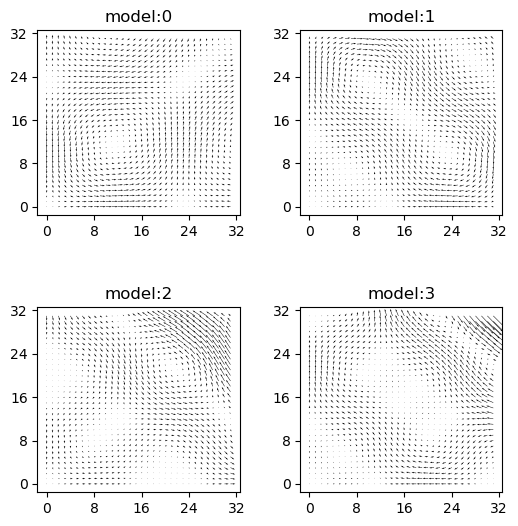

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

Phi, Lam, A = POD(Utx)
print(Phi.shape)
print(Lam.shape)
print(A.shape)

N = 32
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(2, 2, hspace=0.5, wspace=0.3)
for i in range(4):
    row_idx, col_idx = i // 2 + 1, i % 2 + 1
    model_u, model_v = Phi[: N**2, i].reshape(N, N), Phi[N**2 :, i].reshape(N, N)
    plt.subplot(grid[i // 2, i % 2])
    plt.quiver(model_u, model_v)
    plt.title("model:" + str(i))
    plt.xticks([0, 8, 16, 24, 32])
    plt.yticks([0, 8, 16, 24, 32])
plt.show()

## 2. Snapshots POD

correlation matrix:
$$ C_s = U_{tx} \cdot U_{tx}^T \tag{6}$$
eigen value decomposition:
$$ C_s  = A_s \cdot \Lambda_s \cdot A_s^T \tag{7}$$
$A_s$ are the temporal POD modes and eigen values in $\Lambda_s$ is the energy of each mode
spatial coefficients:
$$ \Phi_s = U_{tx}^T \cdot A_s \tag{8}$$


In [22]:
def POD_snapshot(Utx: ndarray) -> tuple[ndarray]:
    Cs = (1/Utx.shape[1])*Utx @ Utx.T
    Lambda_s, As = eig(Cs)
    print(Lambda_s.shape, As.shape)
    Phis = Utx.T @ As
    return Phis, Lambda_s, As

(100,) (100, 100)
(2048, 100)
(100,)
(100, 100)


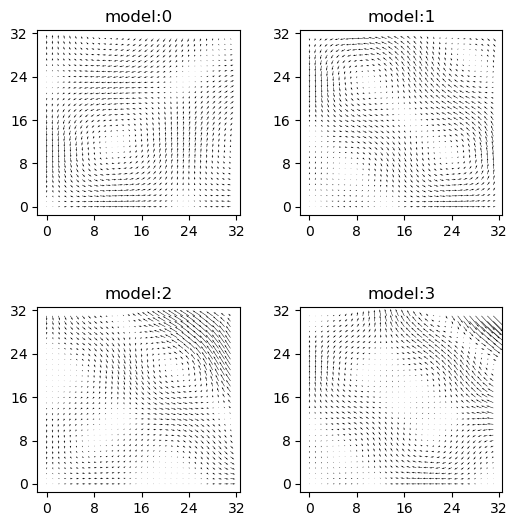

In [23]:
Phis, Lams, As = POD_snapshot(Utx)
print(Phis.shape)
print(Lams.shape)
print(As.shape)

N = 32
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(2, 2, hspace=0.5, wspace=0.3)
for i in range(4):
    row_idx, col_idx = i // 2 + 1, i % 2 + 1
    model_u, model_v = Phis[: N**2, i].reshape(N, N), Phis[N**2 :, i].reshape(N, N)
    plt.subplot(grid[i // 2, i % 2])
    plt.quiver(model_u, model_v)
    plt.title("model:" + str(i))
    plt.xticks([0, 8, 16, 24, 32])
    plt.yticks([0, 8, 16, 24, 32])
plt.show()

## 3. Direct POD(SVD)

singular value decomposition:
$$ U_{tx} = U \cdot \Sigma \cdot V^T \tag{9}$$
compute the matrices C in light of the SVD:
$$\begin{array}{l} 
C = \frac{1}{m-1} U_{tx}^T \cdot U_{tx} \\
= ((U{\Sigma}{V^T})^T(U{\Sigma}{V^T})) \\
= (V {\Sigma}^T {U^T} U {\Sigma} {V^T})\\
= (V({\Sigma^T}{\Sigma})V^T)
\end{array}\tag{10}$$

POD spatial modes, time coefficients and energy :
$$ \Phi = V, A = U, \Lambda = \Sigma^T \cdot \Sigma\tag{11}$$


In [24]:
from numpy.linalg import svd

def POD_SVD(Utx: ndarray) -> tuple[ndarray]:
    data = 1/np.sqrt(Utx.shape[1])*Utx
    U, S, VT = svd(data)
    V = VT.T
    return U, S, V

(2048, 2048)
(100,)
(100, 100)


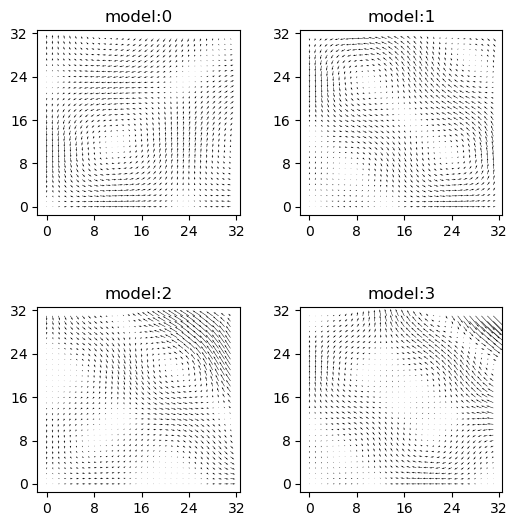

In [25]:

A, S, Phi = POD_SVD(Utx)
print(Phi.shape)
print(S.shape)
print(A.shape)


N = 32
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(2, 2, hspace=0.5, wspace=0.3)
for i in range(4):
    row_idx, col_idx = i // 2 + 1, i % 2 + 1
    model_u, model_v = Phis[: N**2, i].reshape(N, N), Phis[N**2 :, i].reshape(N, N)
    plt.subplot(grid[i // 2, i % 2])
    plt.quiver(model_u, model_v)
    plt.title("model:" + str(i))
    plt.xticks([0, 8, 16, 24, 32])
    plt.yticks([0, 8, 16, 24, 32])
plt.show()